# Merge & clean "activity" table from database

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

out_figures_path = "../../generated/figures/database"
if not os.path.exists(out_figures_path):
    os.makedirs(out_figures_path)

out_generated_path = "../../generated/database"
if not os.path.exists(out_generated_path):
    os.makedirs(out_generated_path)

In [2]:
def get_sessions(dataframe):
    dataframe = dataframe.sort_values('timestamp')

    data_sessions = []
    for group in ['A', 'B']:
        group_data = dataframe[dataframe['group'] == group]
        for mode in ['Leaderboard', 'Achievements']:
            mode_data = group_data[group_data['game_mode'] == mode]
            if len(mode_data) > 0:
                start = mode_data.iloc[0]['timestamp']
                end = mode_data.iloc[-1]['timestamp']

                data_sessions.append({
                    'group': group,
                    'game_mode': mode,
                    'start': start,
                    'theoretical_start': end - pd.Timedelta(minutes=20),
                    'theoretical_end': start + pd.Timedelta(minutes=20),
                    'end': end,
                })

    data_sessions = pd.DataFrame(data_sessions)

    return data_sessions.sort_values(['group', 'start'])


In [3]:
activity = "../../data/database/activity.csv"
df = pd.read_csv(activity)

game_mode = "../../data/database/game_mode.csv"
df_game_mode = pd.read_csv(game_mode)

df = df.merge(df_game_mode, left_on="game_mode", right_on="id", how="left")

df["game_mode"] = df["name"]
df = df.drop(columns=["id_x", "id_y", "name"])
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("Europe/Brussels")

df_without_group = df[[col for col in df.columns if col != 'timestamp'] + ['timestamp']]

# Delete unused achievement data

In [4]:
count_df = df_without_group.groupby('achievement').size().reset_index(name='count').sort_values(by='count', ascending=False)
count_df.to_csv(f"{out_generated_path}/achievements-count.csv", index=False)

In [5]:
asserts_by_users = df_without_group[df_without_group['achievement'] == 'TriggerXAssertsByTestsAchievement'].groupby("user").size().reset_index(name='count').sort_values(by='count', ascending=False)
asserts_by_users.to_csv(f"{out_generated_path}/asserts-by-users.csv", index=False)

In [6]:
df_without_group_without_asserts = df_without_group[df_without_group['achievement'] != 'TriggerXAssertsByTestsAchievement']
df_without_group_without_asserts

,user,achievement,points,game_mode,timestamp
0,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:37.584413+02:00
1,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:37.608230+02:00
2,0d271530-be17-4538-bf04-dde3c6069b5f,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:49.222756+02:00
3,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:58.246131+02:00
4,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:58.276464+02:00
...,...,...,...,...,...
12931,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:54.685880+02:00
12934,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:56.890680+02:00
12949,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:30:03.539677+02:00
13101,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 10:42:15.128917+02:00



# Add group

In [7]:
df_first = df_without_group_without_asserts.sort_values(by=["timestamp"], ascending=True).groupby("user").last().reset_index()
df_first['group'] = df_first['game_mode'].map({'Leaderboard': 'A', 'Achievements': 'B'})
users_groups = df_first[['user', 'group']]
df = df_without_group_without_asserts.merge(users_groups, on='user', how='left')

In [8]:
df_users = pd.read_csv('../../data/database/user.csv')
df_users['created_at'] = pd.to_datetime(df_users['created_at'], utc=True).dt.tz_convert("Europe/Brussels")
df_users['last_update'] = pd.to_datetime(df_users['last_update'], utc=True).dt.tz_convert("Europe/Brussels")

users = df_users.merge(users_groups, left_on='id', right_on='user', how='left')
users = users.drop(columns=['user'])
users = users.rename(columns={'id': 'user'})

users.to_csv(f"{out_generated_path}/users.csv", index=False)
users[pd.isnull(users["group"])].to_csv(f"{out_generated_path}/users_no_activity.csv", index=False)

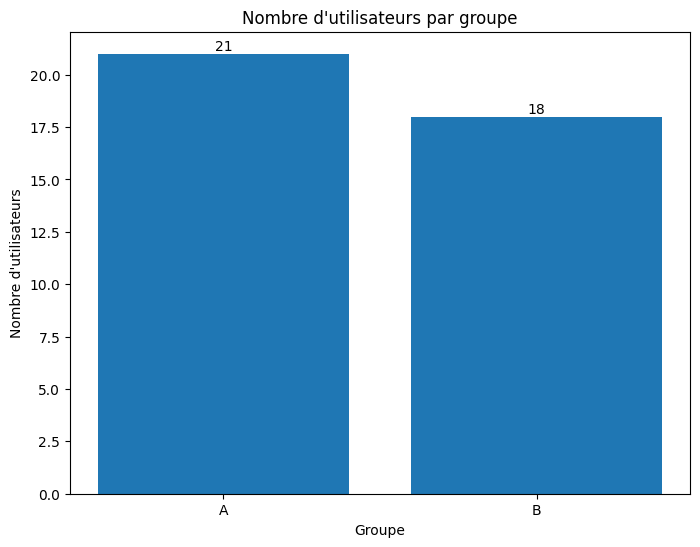

In [9]:
group_counts = users_groups['group'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(group_counts.index, group_counts.values)
plt.title('Nombre d\'utilisateurs par groupe')
plt.xlabel('Groupe')
plt.ylabel('Nombre d\'utilisateurs')

for i, v in enumerate(group_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.savefig(f"{out_figures_path}/group_counts.pdf")
plt.show()

# Remove activity when mode is not valid with experiments settings

## First session

In [10]:
sessions = get_sessions(df)
groups_first_mode = sessions[((sessions["group"] == "A") & (sessions["game_mode"] == "Achievements")) | ((sessions["group"] == "B") & (sessions["game_mode"] == "Leaderboard"))]

timing_data = []

for index, row in groups_first_mode.iterrows():
    timing_data.append([1, row["group"], row["game_mode"], row["start"], row["theoretical_end"]])
    print(f"Group {row["group"]} - {row["game_mode"]} | session 1 : {row["start"]} -> {row["theoretical_end"]}")

invalid_list = []
for _, row in groups_first_mode.iterrows():
    filtered = df[
        (df["group"] == row["group"]) &
        (df["game_mode"] == row["game_mode"]) &
        ((df["timestamp"] < row["start"]) | (df["timestamp"] > row["theoretical_end"]))
    ]

    invalid_list.append(filtered)

wrong_first_mode = pd.concat(invalid_list, ignore_index=True)
print("Invalid wrong mode activity count :", len(wrong_first_mode))
wrong_first_mode

Group A - Achievements | session 1 : 2025-04-17 09:05:22.951686+02:00 -> 2025-04-17 09:25:22.951686+02:00
Group B - Leaderboard | session 1 : 2025-04-17 09:04:05.435083+02:00 -> 2025-04-17 09:24:05.435083+02:00
Invalid wrong mode activity count : 185


,user,achievement,points,game_mode,timestamp,group
0,a7c1124d-d4fc-4fc7-bb6f-b73e2f1b7fdd,RefactorAddXAssertionsAchievement,2,Achievements,2025-04-17 09:27:53.792802+02:00,A
1,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:27:58.790629+02:00,A
2,0d271530-be17-4538-bf04-dde3c6069b5f,RunWithCoverageAchievement,1,Achievements,2025-04-17 09:27:58.805677+02:00,A
3,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:31:23.639522+02:00,A
4,0d271530-be17-4538-bf04-dde3c6069b5f,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:31:37.690236+02:00,A
...,...,...,...,...,...,...
180,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:00:45.641312+02:00,B
181,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:57:14.280267+02:00,B
182,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:54.760661+02:00,B
183,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.611324+02:00,B


In [11]:
cleaned_first_part_df = df.merge(wrong_first_mode, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
cleaned_first_part_df

,user,achievement,points,game_mode,timestamp,group
0,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:37.584413+02:00,A
1,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:37.608230+02:00,A
2,0d271530-be17-4538-bf04-dde3c6069b5f,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:49.222756+02:00,A
3,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:03:58.246131+02:00,A
4,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:03:58.276464+02:00,A
...,...,...,...,...,...,...
2504,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:54.685880+02:00,A
2505,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:29:56.890680+02:00,A
2506,11b1644a-d11f-45cb-8a40-282a209059c0,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 10:30:03.539677+02:00,A
2507,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 10:42:15.128917+02:00,A


In [12]:
sessions = get_sessions(cleaned_first_part_df)

## Get first form submission for second session

In [13]:
forms_data = "../../generated/forms/data.csv"
if not os.path.exists(forms_data):
    raise FileNotFoundError(f"Le fichier {forms_data} n'existe pas. Exécutez le notebook 'notebooks/arrange data/Merge forms data.ipynb' pour le générer.")

form_data_df = pd.read_csv(forms_data, usecols=['Identifiant', 'group', 'Leaderboard Horodateur', 'Achievements Horodateur'])
form_data_df['Leaderboard Horodateur'] = pd.to_datetime(form_data_df['Leaderboard Horodateur'], dayfirst=False)
form_data_df['Achievements Horodateur'] = pd.to_datetime(form_data_df['Achievements Horodateur'], dayfirst=False)

group_a_first_timestamps = form_data_df[form_data_df['group'] == 'A']['Leaderboard Horodateur'].min() - pd.Timedelta(minutes=3)
group_a_first_timestamps = group_a_first_timestamps.tz_localize('Europe/Brussels')
print(f"Group A - leadearboard end time: {group_a_first_timestamps}")

group_b_first_timestamps = form_data_df[form_data_df['group'] == 'B']['Achievements Horodateur'].min() - pd.Timedelta(minutes=3)
group_b_first_timestamps = group_b_first_timestamps.tz_localize('Europe/Brussels')
print(f"Group B - achievements end time: {group_b_first_timestamps}")

Group A - leadearboard end time: 2025-04-17 10:05:54+02:00
Group B - achievements end time: 2025-04-17 10:03:54+02:00


## Second session

In [14]:
sessions = get_sessions(cleaned_first_part_df)
groups_second_mode = (sessions[(
    (sessions["group"] == "A") & (sessions["game_mode"] == "Leaderboard")) |
    ((sessions["group"] == "B") & (sessions["game_mode"] == "Achievements"))
].copy())

groups_second_mode.loc[:, "end"] = groups_second_mode["group"].apply(lambda x: group_a_first_timestamps if x == "A" else group_b_first_timestamps)
groups_second_mode["theoretical_start"] = groups_second_mode["end"] - pd.Timedelta(minutes=20)
groups_second_mode

,group,game_mode,start,theoretical_start,theoretical_end,end
0,A,Leaderboard,2025-04-17 09:03:37.584413+02:00,2025-04-17 09:45:54+02:00,2025-04-17 09:23:37.584413+02:00,2025-04-17 10:05:54+02:00
3,B,Achievements,2025-04-17 09:44:33.184196+02:00,2025-04-17 09:43:54+02:00,2025-04-17 10:04:33.184196+02:00,2025-04-17 10:03:54+02:00


In [15]:
for index, row in groups_second_mode.iterrows():
    timing_data.append([2, row["group"], row["game_mode"], row["theoretical_start"], row["end"]])
    print(f"Group {row["group"]} - {row["game_mode"]} | session 2 : {row["theoretical_start"]} -> {row["end"]}")

filtered_list = []
for _, row in groups_second_mode.iterrows():
    filtered = cleaned_first_part_df[
        (cleaned_first_part_df["group"] == row["group"]) &
        (cleaned_first_part_df["game_mode"] == row["game_mode"]) &
        ((cleaned_first_part_df["timestamp"] < row["theoretical_start"]) | (cleaned_first_part_df["timestamp"] > row["end"]))
    ]

    filtered_list.append(filtered)

wrong_second_mode = pd.concat(filtered_list, ignore_index=True)
print("Invalid wrong mode activity count :", len(wrong_second_mode))
wrong_second_mode[wrong_second_mode['group'] == 'B']

Group A - Leaderboard | session 2 : 2025-04-17 09:45:54+02:00 -> 2025-04-17 10:05:54+02:00
Group B - Achievements | session 2 : 2025-04-17 09:43:54+02:00 -> 2025-04-17 10:03:54+02:00
Invalid wrong mode activity count : 430


,user,achievement,points,game_mode,timestamp,group
378,eed81e54-2343-44af-ab2f-cd062db7e11a,RunWithCoverageAchievement,1,Achievements,2025-04-17 10:03:58.667866+02:00,B
379,eed81e54-2343-44af-ab2f-cd062db7e11a,CoverXLinesAchievement,6,Achievements,2025-04-17 10:03:58.737473+02:00,B
380,eed81e54-2343-44af-ab2f-cd062db7e11a,CoverXMethodsAchievement,4,Achievements,2025-04-17 10:03:58.767917+02:00,B
381,eed81e54-2343-44af-ab2f-cd062db7e11a,CoverXClassesAchievement,1,Achievements,2025-04-17 10:03:58.774456+02:00,B
382,f9ec833e-db4f-49b9-9b14-08298cbb4425,RefactorAddXAssertionsAchievement,4,Achievements,2025-04-17 10:03:54.889272+02:00,B
383,f9ec833e-db4f-49b9-9b14-08298cbb4425,AddTestsAchievement,2,Achievements,2025-04-17 10:03:54.955676+02:00,B
384,eed81e54-2343-44af-ab2f-cd062db7e11a,RefactorAddXAssertionsAchievement,1,Achievements,2025-04-17 10:03:55.199698+02:00,B
385,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Achievements,2025-04-17 10:03:55.206968+02:00,B
386,eed81e54-2343-44af-ab2f-cd062db7e11a,RunXTestSuitesAchievement,1,Achievements,2025-04-17 10:03:56.146393+02:00,B
387,eed81e54-2343-44af-ab2f-cd062db7e11a,RunXTestSuitesAchievement,1,Achievements,2025-04-17 10:03:58.667674+02:00,B


In [16]:
cleaned_df = cleaned_first_part_df.merge(wrong_second_mode, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
cleaned_df

,user,achievement,points,game_mode,timestamp,group
5,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.435083+02:00,B
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
...,...,...,...,...,...,...
2127,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.900757+02:00,A
2128,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:58:59.918734+02:00,A
2129,ca639c6f-a4d1-464c-9b8b-0351617a59b5,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:59:00.145819+02:00,B
2130,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXClassesAchievement,1,Leaderboard,2025-04-17 10:04:08.200373+02:00,A


# Save timing dataframe as csv

In [17]:
timing_df = pd.DataFrame(timing_data, columns=["session", "group", "game_mode", "start", "end"])
timing_df['start'] = pd.to_datetime(timing_df['start']).dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S%z')
timing_df['end'] = pd.to_datetime(timing_df['end']).dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S%z')
timing_df.to_csv(f"{out_generated_path}/timing.csv", index=False)

# Outliers

In [18]:
interaction_counts = cleaned_df.groupby(['game_mode', 'group', 'user'])['achievement'].count().reset_index()
interaction_counts

,game_mode,group,user,achievement
0,Achievements,A,0d271530-be17-4538-bf04-dde3c6069b5f,72
1,Achievements,A,11b1644a-d11f-45cb-8a40-282a209059c0,88
2,Achievements,A,1f06f352-91b6-4373-87ed-5a5070723efb,20
3,Achievements,A,223bf16c-aaad-404f-8a47-61f3ced741e4,20
4,Achievements,A,674eeeb6-2534-419d-8965-63e4400f60c4,12
...,...,...,...,...
56,Leaderboard,B,ca639c6f-a4d1-464c-9b8b-0351617a59b5,15
57,Leaderboard,B,d5082901-d846-4794-82af-2c7db8d50788,6
58,Leaderboard,B,eed81e54-2343-44af-ab2f-cd062db7e11a,53
59,Leaderboard,B,f9ec833e-db4f-49b9-9b14-08298cbb4425,12


In [19]:
outlier_users_by_mode = []

for group in cleaned_df['group'].unique():
    for mode in cleaned_df['game_mode'].unique():
        print(f"Groupe {group} - mode : {mode}")
        mode_group_data = interaction_counts[
            (interaction_counts['game_mode'] == mode) &
            (interaction_counts['group'] == group)
            ]['achievement']

        Q1 = mode_group_data.quantile(0.25)
        Q3 = mode_group_data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"\t{mode} - Bound: ({lower_bound}, {upper_bound})")

        data = mode_group_data[(mode_group_data < lower_bound) | (mode_group_data > upper_bound)]
        mode_group_outliers = data.index
        outlier_users = interaction_counts.iloc[mode_group_outliers]['user'].values
        print(f"\tOutliers: {data.values}  - {outlier_users}\n")
        outlier_users_by_mode.extend(outlier_users)

outliers = list(set(outlier_users_by_mode))
outliers_in_both_modes = list(set([x for x in outlier_users_by_mode if outlier_users_by_mode.count(x) > 1]))

Groupe B - mode : Leaderboard
	Leaderboard - Bound: (1.25, 27.25)
	Outliers: [75 53]  - ['7b25b9f2-5d8e-401e-aefa-ac31e94575d1'
 'eed81e54-2343-44af-ab2f-cd062db7e11a']

Groupe B - mode : Achievements
	Achievements - Bound: (-45.625, 103.375)
	Outliers: [123]  - ['88a83dd8-0ea0-41ad-93ca-d397d796fb37']

Groupe A - mode : Leaderboard
	Leaderboard - Bound: (-45.0, 103.0)
	Outliers: [125]  - ['caadbaac-e919-4b9b-b3a5-9d074d40493c']

Groupe A - mode : Achievements
	Achievements - Bound: (-34.875, 80.125)
	Outliers: [ 88 165]  - ['11b1644a-d11f-45cb-8a40-282a209059c0'
 'caadbaac-e919-4b9b-b3a5-9d074d40493c']



In [20]:
print(f"Outliers : {len(outliers)}")
print(outliers)
print("")
print(f"Outliers in both modes : {len(outliers_in_both_modes)}")
print(outliers_in_both_modes)

Outliers : 5
['7b25b9f2-5d8e-401e-aefa-ac31e94575d1', '88a83dd8-0ea0-41ad-93ca-d397d796fb37', 'caadbaac-e919-4b9b-b3a5-9d074d40493c', 'eed81e54-2343-44af-ab2f-cd062db7e11a', '11b1644a-d11f-45cb-8a40-282a209059c0']

Outliers in both modes : 1
['caadbaac-e919-4b9b-b3a5-9d074d40493c']


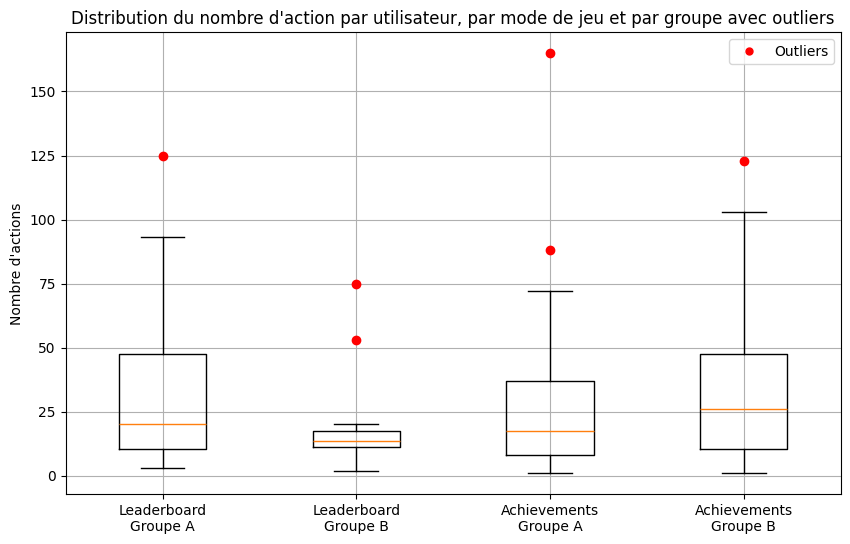

In [21]:
plt.figure(figsize=(10, 6))
color = 'red'

data = []
labels = []

for mode in ['Leaderboard', 'Achievements']:
    for group in ['A', 'B']:
        mode_group_data = cleaned_df[
            (cleaned_df['game_mode'] == mode) &
            (cleaned_df['group'] == group)
            ].groupby('user')['achievement'].count()
        data.append(mode_group_data)
        labels.append(f'{mode}\nGroupe {group}')

plt.boxplot(data, tick_labels=labels, flierprops={'marker': 'o', 'markerfacecolor': color, 'markeredgecolor': color})

plt.title('Distribution du nombre d\'action par utilisateur, par mode de jeu et par groupe avec outliers')
plt.ylabel('Nombre d\'actions')
plt.xticks(rotation=0)
plt.grid(True)

outlier_legend = Line2D([0], [0], marker='o', color='w', label='Outliers', markerfacecolor=color, markeredgecolor=color,
                        markersize=5)
plt.legend(handles=[outlier_legend])
plt.savefig(f"{out_figures_path}/boxplot-outliers.pdf")
plt.show()


## Outliers activity

In [22]:
cleaned_df[cleaned_df['user'].isin(outliers_in_both_modes)]

,user,achievement,points,game_mode,timestamp,group
54,caadbaac-e919-4b9b-b3a5-9d074d40493c,AddTestsAchievement,1,Achievements,2025-04-17 09:06:52.868352+02:00,A
89,caadbaac-e919-4b9b-b3a5-9d074d40493c,RefactorAddXAssertionsAchievement,2,Achievements,2025-04-17 09:07:51.628928+02:00,A
103,caadbaac-e919-4b9b-b3a5-9d074d40493c,RefactorAddXAssertionsAchievement,1,Achievements,2025-04-17 09:08:25.308006+02:00,A
104,caadbaac-e919-4b9b-b3a5-9d074d40493c,AddTestsAchievement,1,Achievements,2025-04-17 09:08:25.319501+02:00,A
106,caadbaac-e919-4b9b-b3a5-9d074d40493c,RunXTestSuitesAchievement,1,Achievements,2025-04-17 09:08:27.224733+02:00,A
...,...,...,...,...,...,...
2121,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXClassesAchievement,1,Leaderboard,2025-04-17 09:58:49.942407+02:00,A
2122,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXClassesAchievement,1,Leaderboard,2025-04-17 09:58:55.256593+02:00,A
2123,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXBranchesAchievement,4,Leaderboard,2025-04-17 09:58:55.256885+02:00,A
2130,caadbaac-e919-4b9b-b3a5-9d074d40493c,CoverXClassesAchievement,1,Leaderboard,2025-04-17 10:04:08.200373+02:00,A


## Final data without outliers

In [23]:
final_df_without_outliners = cleaned_df[~cleaned_df['user'].isin(outliers_in_both_modes)]
final_df_without_outliners

,user,achievement,points,game_mode,timestamp,group
5,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.435083+02:00,B
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
...,...,...,...,...,...,...
2125,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:58:59.236919+02:00,A
2126,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:58:59.259630+02:00,A
2127,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.900757+02:00,A
2128,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:58:59.918734+02:00,A


## Outliers stats

In [24]:
df_len = len(cleaned_df)
final_df_len = len(final_df_without_outliners)

print(f"Original dataset size: {df_len}")
print(f"Number of rows removed: {df_len - final_df_len}")
print(f"Dataset size after removing outliers: {final_df_len}")

Original dataset size: 1894
Number of rows removed: 290
Dataset size after removing outliers: 1604


## Save to csv

In [25]:
final_df_without_outliners

,user,achievement,points,game_mode,timestamp,group
5,eed81e54-2343-44af-ab2f-cd062db7e11a,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.435083+02:00,B
6,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RefactorAddXAssertionsAchievement,2,Leaderboard,2025-04-17 09:04:05.979055+02:00,B
7,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,AddTestsAchievement,1,Leaderboard,2025-04-17 09:04:05.992210+02:00,B
8,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:04:09.168499+02:00,B
9,7b25b9f2-5d8e-401e-aefa-ac31e94575d1,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:04:09.170740+02:00,B
...,...,...,...,...,...,...
2125,11b1644a-d11f-45cb-8a40-282a209059c0,RefactorAddXAssertionsAchievement,1,Leaderboard,2025-04-17 09:58:59.236919+02:00,A
2126,11b1644a-d11f-45cb-8a40-282a209059c0,AddTestsAchievement,1,Leaderboard,2025-04-17 09:58:59.259630+02:00,A
2127,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunXTestSuitesAchievement,1,Leaderboard,2025-04-17 09:58:59.900757+02:00,A
2128,b39dc415-9bb6-4d5d-a8f9-30fd61f6a594,RunWithCoverageAchievement,1,Leaderboard,2025-04-17 09:58:59.918734+02:00,A


In [26]:
final_df_without_outliners.to_csv(f"{out_generated_path}/activity.csv", index=False)
df.to_csv(f"{out_generated_path}/activity-brut.csv", index=False)